## Dataset Synthesation

In this notebook the dataset for image captioning is generated.

In [20]:
# libraries
import numpy as np
import random as rand
import matplotlib.pyplot as plt
import pickle
from tensorflow.examples.tutorials.mnist import input_data
import re
import string
IMAGE_SIZE=40
DATA_SIZE=10000

### 1 Prepare MNIST

#### 1.1 Load MNIST
The MNIST dataset is often used in machine learning and is readily available online [here](http://yann.lecun.com/exdb/mnist/). Load it, and display one of the images to check it works correctly.

In [4]:
# load MNIST dataset
mnist = input_data.read_data_sets("../", one_hot=False)

X_train = np.vstack([img.reshape(-1,) for img in mnist.train.images])
y_train = mnist.train.labels

X_test = np.vstack([img.reshape(-1,) for img in mnist.test.images])
y_test = mnist.test.labels

del mnist

Extracting ../train-images-idx3-ubyte.gz
Extracting ../train-labels-idx1-ubyte.gz
Extracting ../t10k-images-idx3-ubyte.gz
Extracting ../t10k-labels-idx1-ubyte.gz


X_train shape: (55000, 784)
y_train shape: (55000,)
X_test shape: (10000, 784)
y_test shape: (10000,)
784


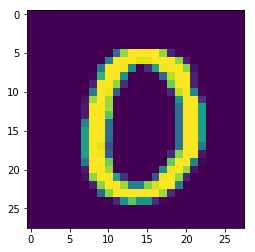

In [5]:
# print shapes and examples
print("X_train shape:", np.shape(X_train))
print("y_train shape:", np.shape(y_train))
print("X_test shape:", np.shape(X_test))
print("y_test shape:", np.shape(y_test))
print(np.size(X_train[10]))
plt.imshow(X_train[10].reshape(28,28))

### 2 Bounding boxes
In order to be able to calculate the overlap between two images we need to know where the digits are, this means that we need a smaller box than the 28x28 pixels that they all fall into. Libraries exist for this.

In [6]:
def trim_img(img):
    i = img.reshape(28,28)
    j = i[~np.all(i==0, axis=1)].T
    return j[~np.all(j==0, axis=1)].T

In [7]:
X_train_bounded = []

for img in X_train:
    X_train_bounded.append(trim_img(img))

20


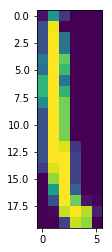

In [8]:
print(np.shape(X_train_bounded[10])[0])
plt.imshow(X_train_bounded[20])

### 3 Create the new image

Now it is time to generate the new images, these images will be 40x40 and contain two digits at random positions in the frame.

#### 3.1 Place a digit randomly
To generate the image the first step is to place a digit at a random position in the 40x40 frame. To do this write a function `place_digit(frame, digit)` which returns a modified `frame`, and a dictionary containing the top left and bottom right positions of the digit in the frame `{x0: , y0: , x1: , y1: }`.

In [9]:
def place_digit(frame, digit):
    '''
    param - frame : 2d numpy array
    param - digit : 2d numpy array
    
    return - new_frame : 2d numpy array (same shape as frame)
    return - position : dictionary containing x0, y0, x1, y1
    '''
    size = IMAGE_SIZE
    new_frame = frame
    digit_y = np.shape(digit)[0]
    digit_x = np.shape(digit)[1]
    y_limit=int(digit_y/2)
    x_limit=int(digit_x/2)
    location_x = rand.randrange(x_limit,size-x_limit)
    location_y = rand.randrange(y_limit,size-y_limit)
    x0=location_x-x_limit
    y0=location_y-y_limit
    x1=location_x+x_limit+digit_x%2
    y1=location_y+y_limit+digit_y%2
   # print(digit.shape)
    position={'x0':x0,'y0':y0,'x1':x1,'y1':y1,'c':[location_y,location_x]}
    #print(position)
   # print(new_frame[y0:y1,x0:x1].shape)
    new_frame[y0:y1,x0:x1]=np.maximum(new_frame[y0:y1,x0:x1],digit)
    
    
    return new_frame, position

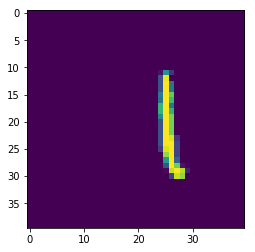

In [10]:
frame = np.zeros((40,40))
frame,pos=place_digit(frame,X_train_bounded[20])
plt.imshow(frame)


[16, 21]
21


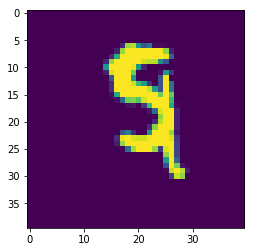

In [11]:
frame,pos=place_digit(frame,X_train_bounded[60])
plt.imshow(frame)
print(pos['c'])
print(pos['c'][1])

#### 3.2 Create the full image
The full image together with the information needed for the caption can now be generated. This is done in a number of steps:

1. Select two random digits
2. Place the digits in the frame
3. Calculate the intersection over union of the digit bounding boxes
4. Calculate the center locations of the digits

In [61]:
def gen_image(shape, X, Y):
    '''
    param - shape : tuple containing height and width of the images
    
    return - frame : 2d numpy array of shape shape
    return - info : dictionary containing information about the frame
    '''
    frame = np.zeros((shape,shape))
    
    # select digits
    while True:
        n1 = rand.randrange(0,np.shape(X)[0])
        digit1 = X[n1]
        digit1_y = Y[n1]
        #print(n1)
        n2 = rand.randrange(0,np.shape(X)[0])
        digit2 = X[n2]
        digit2_y = Y[n2]
        if(digit1_y!=digit2_y):
            frame = np.zeros((shape,shape))
            frame, pos1 = place_digit(frame, digit1)
            frame, pos2 = place_digit(frame, digit2)


            i=min(max(pos1['x1']-pos2['x0'],0),max(pos2['x1']-pos1['x0'],0))*\
            min(max(pos1['y1']-pos2['y0'],0),max(pos2['y1']-pos1['y0'],0))
            u=np.size(X[n1])+np.size(X[n2])-i
            # calc iou and centers
            iou = i/u
            if(iou<0.01):
                break
    
    #print(n2)
    # place digits

    c1 = pos1['c']
    c2 = pos2['c']
    
    # the info needed for generating the caption
    info = {'y1': digit1_y, 'y2': digit2_y, 'iou': iou, 'c1': c1, 'c2': c2}
    
    return frame, info

{'y1': 5, 'y2': 8, 'iou': 0.0, 'c1': [10, 24], 'c2': [28, 12]}


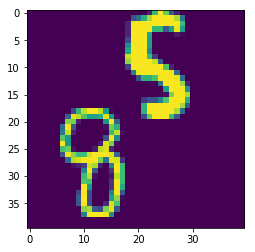

In [62]:
shape=IMAGE_SIZE
frame12,info=gen_image(shape,X_train_bounded,y_train)
plt.imshow(frame12)
print(info)

### 4 Generate caption
Now that the image is done the information about what is inside can be used to generate the ground-truth image caption. Complete the function `gen_caption(info)` so that it returns the caption as a string.

In [63]:
def gen_index(center):
    idx=[0,0]
    if center[0]<25 and center[0]>15:
        idx[0]=1        
    elif center[0]<25:
        idx[0]=2
    if center[1]<25 and center[1]>15:
        idx[1]=1        
    elif center[1]<25:
        idx[1]=2
    return (idx)

In [64]:
def gen_text(digits,idx1,idx2,pos_y1,pos_y2):
    if(idx1[0]>idx2[0]):
        text=[str(digits[0]),str(digits[1]),pos_y1,pos_y2 ]
        if(idx1[0]==1 and idx1[1]==1):
            text[2][1]=""
        if(idx2[0]==1 and idx2[1]==1):
            text[3][1]=""
    elif (idx1[0]<idx2[0]):
        text=[str(digits[1]),str(digits[0]),pos_y2,pos_y1 ]
        if(idx1[0]==1 and idx1[1]==1):
            text[3][1]=""
        if(idx2[0]==1 and idx2[1]==1):
            text[2][1]=""
    elif (idx1[1]>idx2[1]):
        text=[str(digits[0]),str(digits[1]),pos_y1,pos_y2 ]
        if(idx1[0]==1 and idx1[1]==1):
            text[2][1]=""
        if(idx2[0]==1 and idx2[1]==1):
            text[3][1]=""
    elif (idx1[1]<idx2[1]):
        text=[str(digits[1]),str(digits[0]),pos_y2,pos_y1 ]
        if(idx1[0]==1 and idx1[1]==1):
            text[3][1]=""
        if(idx2[0]==1 and idx2[1]==1):
            text[2][1]=""
    else:
        text=0
        return text
    return text

In [65]:
def gen_caption(info):
    '''
    param - info : information about the image
    
    return - caption : 2d numpy array containing word vectors
    '''
    positionY=['Bottom','Center','Top']
    positionX=['Right','Center','Left']
    center=[15,25]
    idx1=gen_index(info['c1'])
    pos_y1=[positionY[idx1[0]],positionX[idx1[1]]]
    
    
    
    
    idx2=gen_index(info['c2'])
    pos_y2=[positionY[idx2[0]],positionX[idx2[1]]]
    
    digits=[info['y1'],info['y2']]
    
    text=gen_text(digits,idx1,idx2,pos_y1,pos_y2)
    if (text):
        if (text[2][1]==""):
            caption="Digit "+str(text[0])+" is at the "+text[2][0]+" while digit "+str(text[1])+" is at the "+text[3][0]+", "+text[3][1]
        elif (text[3][1]==""):
            caption="Digit "+str(text[0])+" is at the "+text[2][0]+", "+text[2][1]+" while digit "+str(text[1])+" is at the "+text[3][0]
        else:
            caption="Digit "+str(text[0])+" is at the "+text[2][0]+", "+text[2][1]+" while digit "+str(text[1])+" is at the "+text[3][0]+", "+text[3][1]
    else:
        caption="Both the digits which are "+str(digits[0])+" and "+str(digits[1])+ " are at "+pos_y1[0]+", "+pos_y1[1]+" of the image"
    return caption

In [66]:
def word_vector(caption):
    list_of_words={'digit':1,'digits':2,'is':3,'are':4,'both':5,'the':6,'at':7,'while':8,'bottom':9,'center':10,'top':11,'left':12,'right':13,'which':14,'and':15,'of':16,'image':17, 'XQX':18}
    word_vec=[]
    FixCapVectSize = 19 
    NoOfDig = 10 #Number of digits to be identified
    caption=caption.lower()
    caption = caption.translate("".maketrans(string.punctuation,'                                '))
    CapVect = re.split(' +',caption)
    Count = FixCapVectSize - len(CapVect)
    while (Count > 0):
       CapVect.append('XQX')
       Count = Count - 1
    for i in CapVect:
        IntWordVect = np.zeros(len(np.unique(np.asarray(list(list_of_words.values())))) + NoOfDig +1) #Creating place holder of one hot code for a single word
        if (i.isdigit()):
            IntWordVect[len(np.unique(np.asarray(list(list_of_words.values())))) + int(i)]=1
            word_vec.append(IntWordVect)
        else:
            IntWordVect[list_of_words[i]-1]=1
            word_vec.append(IntWordVect)
    return word_vec

In [81]:
caption=gen_caption(info)
print(caption)
print(word_vector(caption))
position=['Bottom','top','Left','Right','Center']

Digit 5 is at the Top, Center while digit 8 is at the Bottom, Left
[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0

### 5 Generate dataset
Use the functions created above to generate a full dataset of new images with captions. Implement the following steps:

1. generate an image
2. generate a caption
3. append both to their respective lists

In [68]:
def gen_dataset(shape, length, X, Y):
    '''
    param - shape : shape of the images
    param - length : amount of images to be generated
    param - X : list containing 2d numpy arrays which are the images
    param - Y : numpy array containing image labels
    
    return - imgs : 2d numpy array of frames, each frame is turned into a vector
    return - captions : 3d numpy array containing arrays of word vectors
    '''
    
    imgs = []
    captions = []
    word_vec=[]
    for i in range(length):
        img,info=gen_image(shape,X,Y)
        caps=gen_caption(info)
        word_vect=word_vector(caps)
        
        imgs.append(img)
        captions.append(caps)
        word_vec.append(word_vect)
        if i % 100 == 0:
            print(str(i) + "/" + str(length))
    
    
    return imgs, captions, word_vec

### 6 Store the dataset
Write the dataset to file so that it can be used elsewhere

In [83]:
length=DATA_SIZE
shape=IMAGE_SIZE
imgs,captions,word_vec=gen_dataset(shape,length,X_train_bounded,y_train)
#print(word_vec[1])

0/100


Digit 8 is at the Top, Left while digit 1 is at the Top, Right


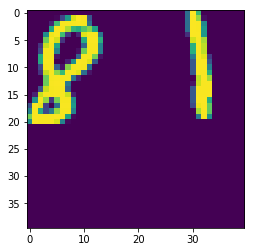

In [91]:
plt.imshow(imgs[24])
print(captions[24])
with open('images.pickle','wb') as F:   
    pickle.dump(imgs,F)
with open('captions.pickle','wb') as G:
    pickle.dump(captions,G)
with open('word_vec.pickle','wb') as G:
    pickle.dump(word_vec,G)

(100, 40, 40)
(100, 19, 29)


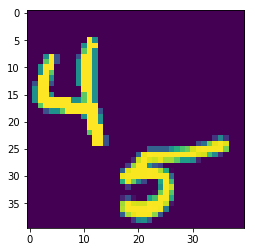

In [76]:
pkl_file = open('images.pickle', 'rb')
images = pickle.load(pkl_file)
pkl_file = open('word_vec.pickle', 'rb')
captions = pickle.load(pkl_file)
plt.imshow(images[4])
#print(captions[20])
images=np.asarray(images)
print(images.shape)
captions=np.asarray(captions)
print(captions.shape)

In [77]:
b=np.zeros((25))
b[2]

0.0

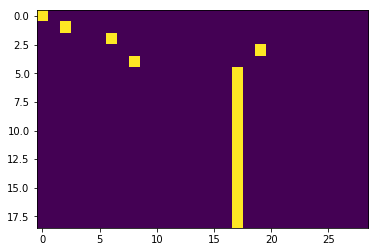

In [78]:
test = word_vector("digit is at 1 bottom")
plt.imshow(test)